In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

# Load Data
Data can be downloaded from [Kaggle](https://www.kaggle.com/datasets/wordsforthewise/lending-club?datasetId=902). Information about the columns can be seen here on [google drive](https://drive.google.com/file/d/1UzyKMtrzL3aEEQpeYIz_qjBWyW-lAMr0/view).

In [2]:
accepted_df = pd.read_csv(filepath_or_buffer="data/raw/accepted_2007_to_2018Q4.csv")
#rejected_df = pd.read_csv(filepath_or_buffer="data/raw/rejected_2007_to_2018Q4.csv")

/var/folders/h0/sqy12xn11_gg038734m010lh0000gn/T/ipykernel_67005/4258043331.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_df = pd.read_csv(filepath_or_buffer="data/raw/accepted_2007_to_2018Q4.csv")


In [3]:
# Take on subset of the whole data to better work with it
# TODO: Delete this later for the final fit of our model(s)
# Attention: For NaNs Identification etc... use full dataset
#n_sample = 50000
#accepted_df = accepted_df.sample(n=n_sample)
#rejected_df = rejected_df.sample(n=n_sample)

In [4]:
# Get number of rows apriori of preprocessing
N = accepted_df.shape[0]

# Print information about raw datasets
print(f"Shape of accepted_df: {accepted_df.shape}")
#print(f"Shape of rejected_df: {rejected_df.shape}")

Shape of accepted_df: (2260701, 151)


In [5]:
accepted_df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning
In this section we remove features that contain too many NaNs and which are also not (or less) relevant for our prediction.

In [6]:
# Compute fraction of NaNs in each Attribute
null_count_series = accepted_df.isna().sum().div(N)
# Sort descending
null_count_series = null_count_series.sort_values(ascending=False)

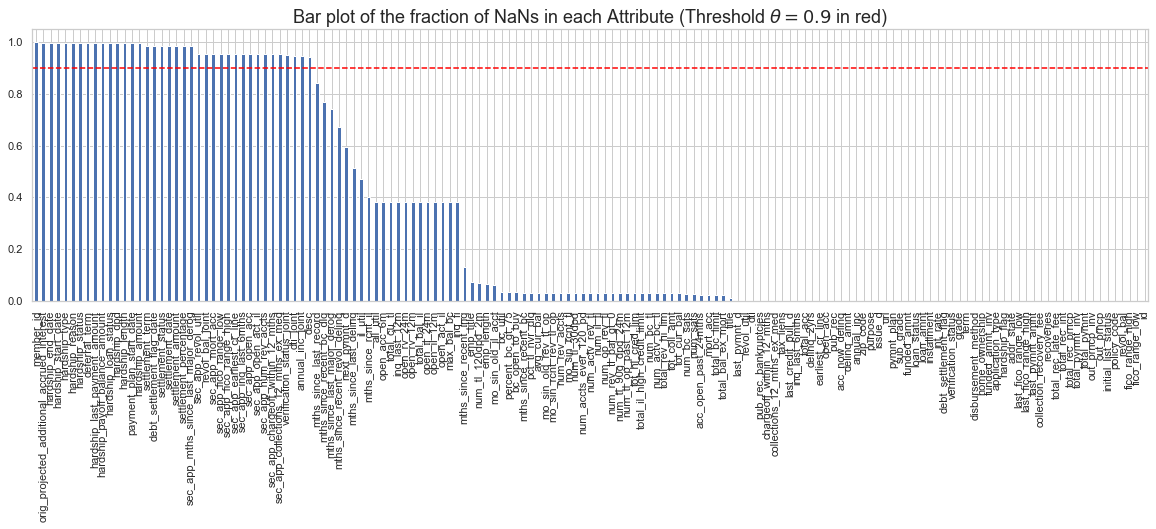

In [15]:
# Define threshold theta: Each column with more or equal NaNs than the threshold will be removed.
threshold = 0.9

plt.figure(figsize=(20,5))
plt.title(f"Bar plot of the fraction of NaNs in each Attribute (Threshold $\\theta = {threshold}$ in red)", size=18)
null_count_series.plot.bar()
# Add threshold as red line
plt.axhline(y=threshold, color="red", linestyle = "--")
plt.show()

In [8]:
# Remove all rows where the NaN Fraction is >= threshold.
null_count_series_cut = null_count_series[null_count_series.values < threshold]

In [10]:
# Get column names of the features with NaN fraction < threshold
columns_post_nan_cut = list(null_count_series_cut.index)
# Keep all columns in accepted_df that are in columns_post_nan_cut
accepted_df = accepted_df.drop([col for col in accepted_df.columns if col not in columns_post_nan_cut], axis=1)

In [11]:
accepted_df.head(5)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,...,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N


## Feature Selection based on Description
In this section we remove irrelevant features based on the official details list. For example, the attributes contain dates add no (or less) information for our model(s). Also columns like the 'url' are not relevant.

TODO: Do Feature Selection BEFORE NaNs Removal

In [ ]:
# Todo